# Multi-variate Rregression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [693]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Generate random (equivalent to Latin Hypercube sampling done in Optislang) feature vectors

In [694]:
X=np.array(10*np.random.randn(37,5))

In [695]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [696]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,-15.997601,-4.933278,-5.206895,-2.417936,1.024404
1,-13.339343,-3.551986,2.776823,22.302992,0.698927
2,-14.903377,4.531416,-12.613780,-10.810093,3.126361
3,-0.823381,-1.298061,9.710988,2.123858,-3.908869
4,-12.360237,7.809253,2.944835,-18.778127,5.706142


### Plot the random distributions of input features

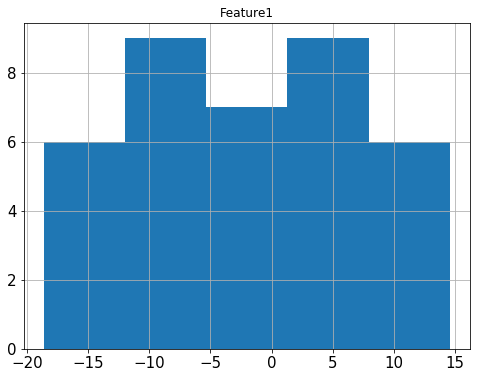

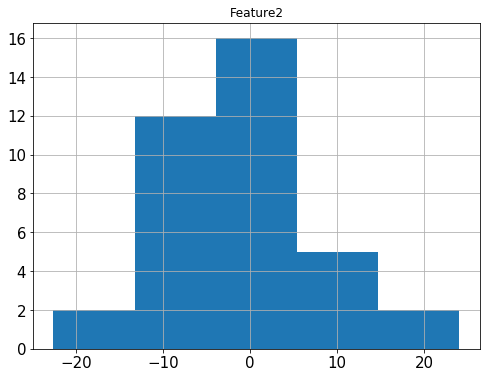

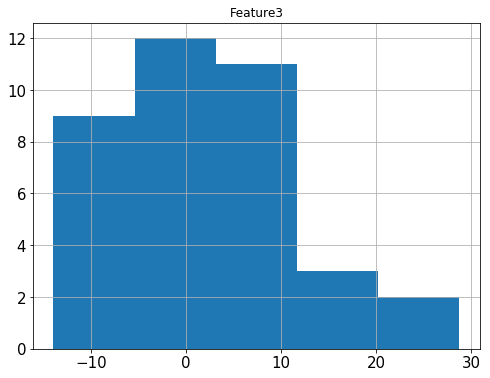

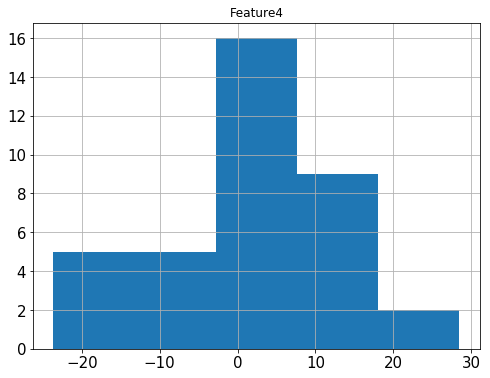

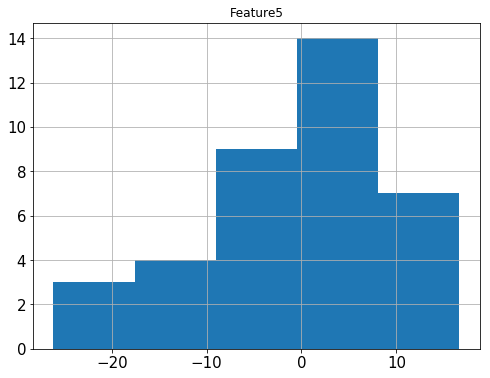

In [697]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

$$ The\ ground\ truth\ or\ originating\ function\ is\ as\ follows:\  $$
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.001x_3+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x) $$

$$: \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}} $$

In [698]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.001*df['Feature3'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+30*np.random.normal(loc=5,scale=2)

In [699]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,-15.997601,-4.933278,-5.206895,-2.417936,1.024404,1331.679988
1,-13.339343,-3.551986,2.776823,22.302992,0.698927,797.727079
2,-14.903377,4.531416,-12.613780,-10.810093,3.126361,1597.202853
3,-0.823381,-1.298061,9.710988,2.123858,-3.908869,58.764862
4,-12.360237,7.809253,2.944835,-18.778127,5.706142,1818.552406


### Plot single-variable scatterplots

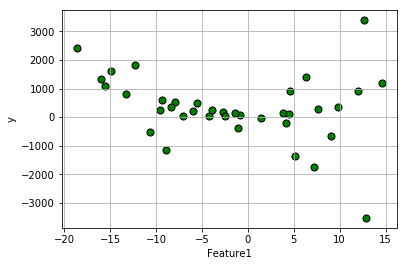

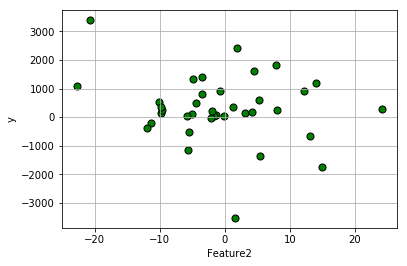

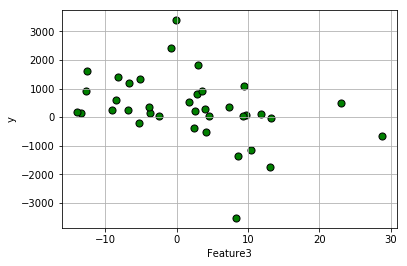

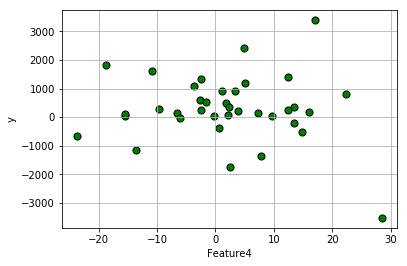

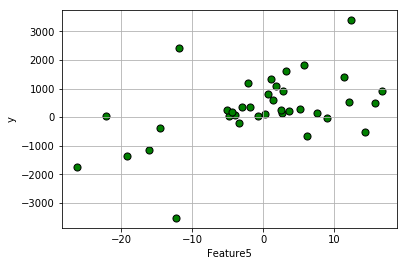

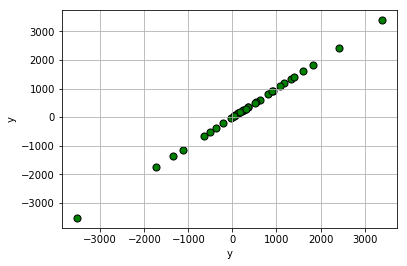

In [700]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True)

### Standard linear regression

In [701]:
from sklearn.linear_model import LinearRegression

In [702]:
linear_model = LinearRegression(normalize=True)

In [703]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']

In [704]:
linear_model.fit(X_linear,y_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [705]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [706]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [707]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 5349.06032837


In [708]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,-15.244173
Feature2,-19.749180
Feature3,-43.427112
Feature4,-19.908951
Feature5,45.823419


In [709]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.418398209757


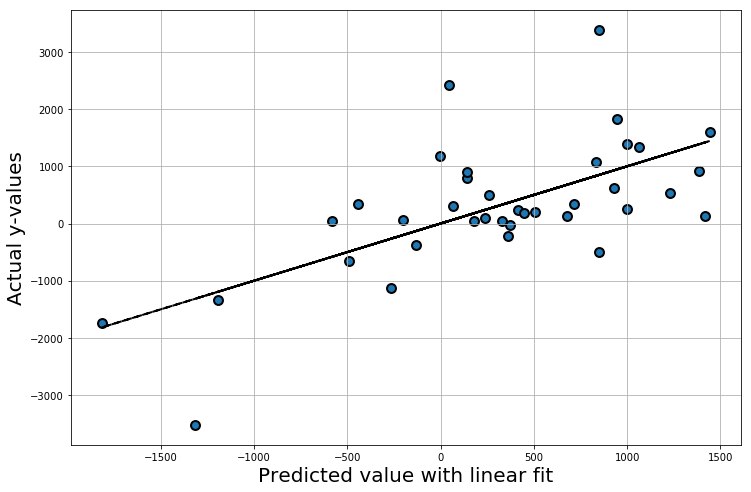

In [710]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [711]:
from sklearn.preprocessing import PolynomialFeatures

In [712]:
poly = PolynomialFeatures(3,include_bias=False)

In [713]:
X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature1^2', 'Feature1 Feature2', 'Feature1 Feature3', 'Feature1 Feature4', 'Feature1 Feature5', 'Feature2^2', 'Feature2 Feature3', 'Feature2 Feature4', 'Feature2 Feature5', 'Feature3^2', 'Feature3 Feature4', 'Feature3 Feature5', 'Feature4^2', 'Feature4 Feature5', 'Feature5^2', 'Feature1^3', 'Feature1^2 Feature2', 'Feature1^2 Feature3', 'Feature1^2 Feature4', 'Feature1^2 Feature5', 'Feature1 Feature2^2', 'Feature1 Feature2 Feature3', 'Feature1 Feature2 Feature4', 'Feature1 Feature2 Feature5', 'Feature1 Feature3^2', 'Feature1 Feature3 Feature4', 'Feature1 Feature3 Feature5', 'Feature1 Feature4^2', 'Feature1 Feature4 Feature5', 'Feature1 Feature5^2', 'Feature2^3', 'Feature2^2 Feature3', 'Feature2^2 Feature4', 'Feature2^2 Feature5', 'Feature2 Feature3^2', 'Feature2 Feature3 Feature4', 'Feature2 Feature3 Feature5', 'Feature2 Feature4^2', 'Feature2 Feature4 Feature5', 'Feature2 Feature5^2', 'Feature3^3', 'Feature3^2 Feature4', 'F

In [714]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^3,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3
0,-15.997601,-4.933278,-5.206895,-2.417936,1.024404,255.923235,78.920608,83.297821,38.681179,-16.387999,...,-141.168027,-65.554484,27.773374,-30.441669,12.897178,-5.464129,-14.136260,5.989089,-2.537389,1.075012
1,-13.339343,-3.551986,2.776823,22.302992,0.698927,177.938074,47.381163,-37.040998,-297.507257,-9.323222,...,21.411383,171.972737,5.389247,1381.256972,43.285553,1.356474,11094.030682,347.662498,10.894977,0.341425
2,-14.903377,4.531416,-12.613780,-10.810093,3.126361,222.110655,-67.533399,187.987929,161.106894,-46.593337,...,-2006.946516,-1719.966397,497.427335,-1474.022542,426.298506,-123.288763,-1263.247036,365.340630,-105.659283,30.557466
3,-0.823381,-1.298061,9.710988,2.123858,-3.908869,0.677956,1.068798,-7.995839,-1.748744,3.218487,...,915.778221,200.286858,-368.619252,43.804083,-80.619510,148.376703,9.580248,-17.632029,32.450983,-59.724623
4,-12.360237,7.809253,2.944835,-18.778127,5.706142,152.775468,-96.524222,-36.398865,232.102102,-70.529267,...,25.537777,-162.844958,49.483979,1038.402090,-315.541037,95.884000,-6621.506188,2012.088528,-611.416818,185.792285


In [715]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3,y
0,-15.997601,-4.933278,-5.206895,-2.417936,1.024404,255.923235,78.920608,83.297821,38.681179,-16.387999,...,-65.554484,27.773374,-30.441669,12.897178,-5.464129,-14.136260,5.989089,-2.537389,1.075012,1331.679988
1,-13.339343,-3.551986,2.776823,22.302992,0.698927,177.938074,47.381163,-37.040998,-297.507257,-9.323222,...,171.972737,5.389247,1381.256972,43.285553,1.356474,11094.030682,347.662498,10.894977,0.341425,797.727079
2,-14.903377,4.531416,-12.613780,-10.810093,3.126361,222.110655,-67.533399,187.987929,161.106894,-46.593337,...,-1719.966397,497.427335,-1474.022542,426.298506,-123.288763,-1263.247036,365.340630,-105.659283,30.557466,1597.202853
3,-0.823381,-1.298061,9.710988,2.123858,-3.908869,0.677956,1.068798,-7.995839,-1.748744,3.218487,...,200.286858,-368.619252,43.804083,-80.619510,148.376703,9.580248,-17.632029,32.450983,-59.724623,58.764862
4,-12.360237,7.809253,2.944835,-18.778127,5.706142,152.775468,-96.524222,-36.398865,232.102102,-70.529267,...,-162.844958,49.483979,1038.402090,-315.541037,95.884000,-6621.506188,2012.088528,-611.416818,185.792285,1818.552406


In [716]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [717]:
poly = LinearRegression(normalize=True)

In [718]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 8.2683089397e-12


In [719]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,-6.624777
Feature2,12.686454
Feature3,3.230111
Feature4,0.576794
Feature5,4.050511
Feature1^2,5.124386
Feature1 Feature2,-0.165458
Feature1 Feature3,0.230375
Feature1 Feature4,0.547155
Feature1 Feature5,1.803322


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [720]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Metamodel (Optislang style :) - polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [721]:
from sklearn.linear_model import LassoCV

In [722]:
model1 = LassoCV(cv=10,verbose=1,normalize=True,eps=0.001,n_alphas=100, tol=0.0001)

In [723]:
model1.fit(X_train,y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [724]:
y_pred1 = np.array(model1.predict(X_train))

In [725]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 15.0060088036


In [726]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,-0.000000
Feature2,12.763041
Feature3,-0.000000
Feature4,-0.000000
Feature5,0.078203
Feature1^2,4.988110
Feature1 Feature2,-0.000000
Feature1 Feature3,-0.000000
Feature1 Feature4,0.000000
Feature1 Feature5,0.003252


In [727]:
model1.score(X_train,y_train)

0.99999542278685583

### Printing only the non-zero coefficients of the *metamodel*

In [728]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature2,12.763041
Feature5,0.078203
Feature1^2,4.988110
Feature1 Feature5,0.003252
Feature4 Feature5,1.983644
Feature1^2 Feature3,-0.000369
Feature1 Feature4 Feature5,0.798465
Feature4^2 Feature5,0.000398
Feature5^3,0.099561


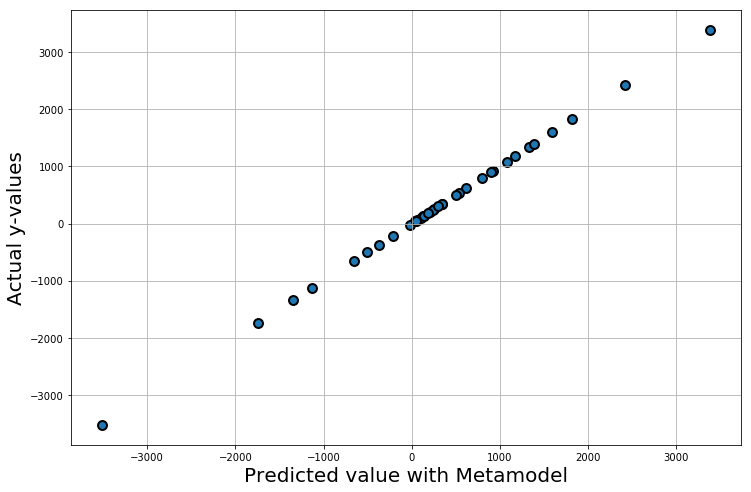

In [729]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)

(-2.3488899597733495,
 0.95111004022665036,
 -219411.05940234032,
 4607686.1897116499)

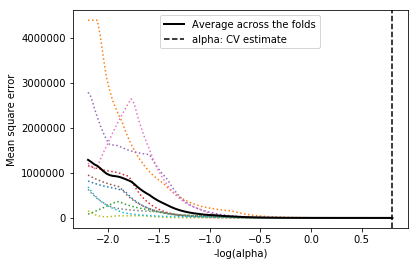

In [730]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')